C:\Users\Steven\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[['D:\\ML projet gallinari\\train set 1\\100.wav' '1']
 ['D:\\ML projet gallinari\\train set 1\\100180.wav' '1']
 ['D:\\ML projet gallinari\\train set 1\\100181.wav' '0']
 ...
 ['D:\\ML projet gallinari\\train set 1\\99452.wav' '1']
 ['D:\\ML projet gallinari\\train set 1\\99453.wav' '1']
 ['D:\\ML projet gallinari\\train set 1\\99687.wav' '1']]
['D:\\ML projet gallinari\\train set 1\\104485.wav' '1']


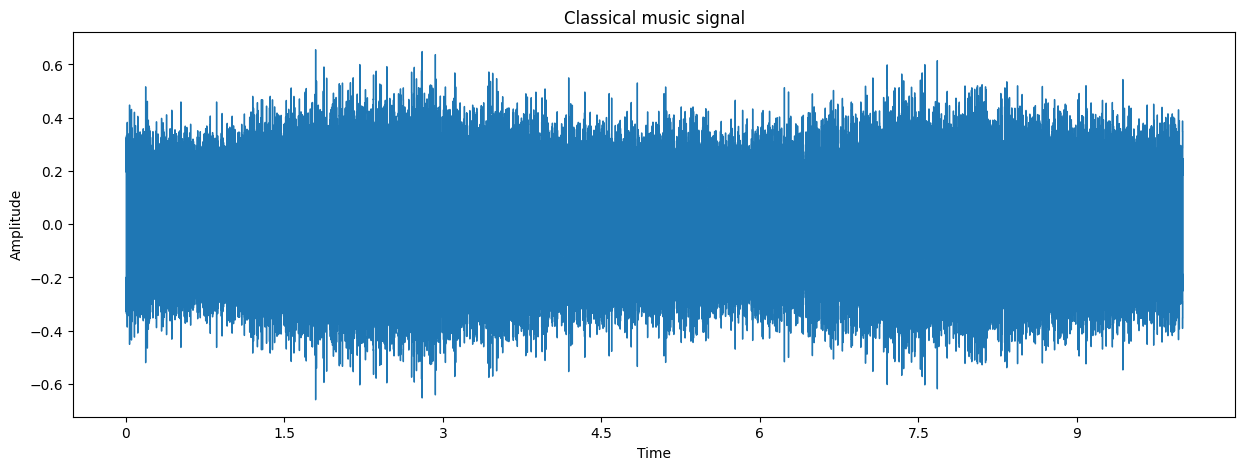

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:<512>'
import librosa
from glob import glob
import numpy as np
import librosa.display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from python_speech_features import mfcc,logfbank
from tqdm import tqdm
from scipy.io import wavfile
import os
from torch.utils.data import Dataset
import torchaudio
import scipy.fftpack
from pysndfx import AudioEffectsChain




T=10
b = (np.sqrt(1 + 4* T**2) - 1) / (2 * T**2)



#séparation des donnés qui ne sont pas du bruit  ( train set 1)

path_sound=r"D:\ML projet gallinari\train set 1\*.wav"
path_excel_file = r"D:\ML projet gallinari\train set 1.csv"


#recuperer son label

df = pd.read_csv(r"D:\ML projet gallinari\train set 1.csv")

df.set_index("itemid",inplace=True)




def get_files_label(path_sound_file,path_excel_file):
    files = []
    label = []
    
    audio_files = glob(path_sound)
    df = pd.read_csv(path_excel_file)
    df.set_index("itemid",inplace=True)
    
    for i in audio_files:
        s =  int(i.split()[-1].split("\\")[-1].split(".")[0])
        files.append(i)
        label.append(df.loc[s]["hasbird"])
        
    return np.column_stack((files,label))


Data = get_files_label(path_sound,path_excel_file)
print(Data)

data1 = Data[Data[:,1]=="1"]
data2 = Data[Data[:,1]=="0"]




#normalisation des donnés :
#test sur le premier son

signal , sr = librosa.load(data1[60,0])





print(data1[60,:])








plt.figure(figsize=(15,5))
librosa.display.waveshow(signal , sr = sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Classical music signal")
plt.show()




In [3]:
#fonction utiles pour la normalisation





def get_melspectrogram(path, fixed_width = 135, fixed_height = 150):
    #  Our images' sample rate is 16000, which is different to the library's default
    """signal, sample_rate = librosa.load(path, sr = 16000)
    hop_length = int(signal.shape[0] / (fixed_width * 1.1))
    spectrogram = librosa.feature.melspectrogram(signal, n_mels = fixed_height, hop_length = hop_length)
    spectrogram = librosa.power_to_db(spectrogram)"""
    hop_length = int(signal.shape[0] / (fixed_width * 1.1))

    y, sr = librosa.load(path)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, power=2)

    log_S = librosa.amplitude_to_db(S, ref=np.max)

    pcen_S = librosa.pcen(S*(2**31)  ,hop_length=hop_length,sr=sr,power=2,gain=0.98,bias=1,max_size=2)

    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

    img = librosa.display.specshow(log_S, x_axis='time', y_axis='mel', ax=ax[0])

    ax[0].set(title='log amplitude (dB)', xlabel=None)

    ax[0].label_outer()

    imgpcen = librosa.display.specshow(pcen_S, x_axis='time', y_axis='mel', ax=ax[1])

    ax[1].set(title='Per-channel energy normalization')

    fig.colorbar(img, ax=ax[0], format="%+2.0f dB")

    fig.colorbar(imgpcen, ax=ax[1])
    

    
    
    return pcen_S


Size = 431
M = np.random.rand(6,420)


def normalize_val_to_train(Matrix):
    
    if Matrix.shape[1]<Size:
        for i in range(Size-Matrix.shape[1]):
            m= (np.mean(Matrix,axis=1).T)
            m=np.expand_dims(m,axis=1)
            Matrix=np.concatenate((Matrix,m),axis=1)
            
            
    else:
        
        Matrix = Matrix[:,0:Size]
    
    return Matrix
    
    
    


    



array([[1.06964113e+02, 7.72532070e+00, 1.39330676e+00, ...,
        1.42430450e+00, 4.87622777e-01, 3.95365684e+00],
       [1.14517411e+02, 4.30789403e+01, 2.12509686e+01, ...,
        7.08559684e-01, 2.44385388e+00, 5.62443649e+00],
       [1.15392443e+02, 4.37883687e+01, 2.41224886e+01, ...,
        9.71806911e+00, 7.75329924e+00, 4.02325741e+00],
       ...,
       [7.98817718e+01, 2.28986202e+01, 6.45923379e+00, ...,
        1.13929044e+00, 1.02605266e+00, 9.24795402e-01],
       [4.04501007e+00, 2.64191391e+00, 1.04941711e+00, ...,
        1.44874841e-01, 2.65217805e-01, 4.33696186e-01],
       [4.51708505e-01, 1.90404852e-01, 1.66639920e-01, ...,
        3.50734369e-02, 5.87063358e-02, 1.04924055e-01]])

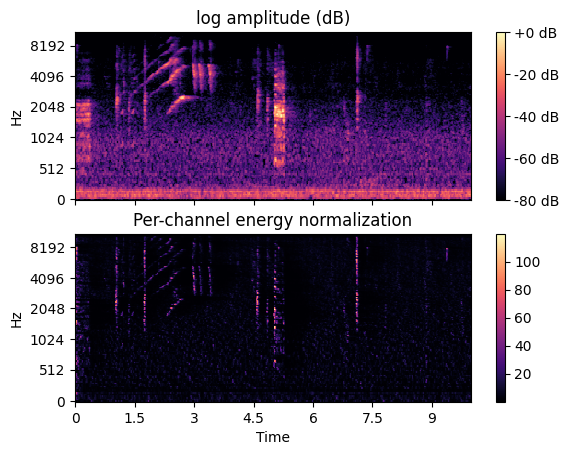

In [7]:
get_melspectrogram(data1[150,0])


In [8]:
print(get_melspectrogram(data2[16,0]).shape)



(128, 431)


In [5]:
#implenter la lecture du validation set 
# implemtner le modèle de machine learning 

In [6]:
path= r"D:\ML projet gallinari\train set 2\*.wav"
path_label = r"D:\ML projet gallinari\train set 2.csv"

def get_files_label_validation(path_sound_file,path_excel_file):
    files = []
    label = []
    
    audio_files = glob(path_sound_file)

    
    df = pd.read_csv(path_excel_file)
    df.set_index("itemid",inplace=True)
    df.index.astype(str, copy = False)
   
    
    for i in audio_files:
        s= (i.split("\\")[-1]).split(".")[0]
        
        files.append(i)
        label.append(df.loc[s]["hasbird"])
        
    return np.column_stack((files,label))


dataval = get_files_label_validation(path,path_label)





#il reste a creer les donnée de test (on le fera plus tard )

In [8]:
def audio_to_images_librosa():
    Data_train = get_files_label(path_sound,path_excel_file)
    Data_val  =  get_files_label_validation(path,path_label)
    print("generating melspectrogram for training..")
    training_images = np.zeros((Data_train.shape[0], 128, 431))
    j=0
    print(training_images.shape)
    for index,file in tqdm(enumerate(Data_train[:,0])):
        
        training_images[index] = get_melspectrogram(file)
        pass
        
        
    np.save('D:\ML projet gallinari\Mel_train\Mel_train.npy', training_images)
        
    return training_images
    

audio_to_images_librosa()

generating melspectrogram for training..
(7690, 128, 431)


6it [00:01,  3.27it/s]


KeyboardInterrupt: 

In [86]:
Data_val  =  get_files_label_validation(path,path_label)

print("generating melspectrogram for validation..")
val_images = np.zeros((Data_val.shape[0], 128, 431))


for index,file in tqdm(enumerate(Data_val[:,0])):
    
    val_images[index] = normalize_val_to_train(get_melspectrogram(file))
    
    pass
    
        
        
np.save('D:\ML projet gallinari\Mel_train\Mel_val.npy', val_images)

generating melspectrogram for validation..


8000it [29:49,  4.47it/s]


NameError: name 'training_images' is not defined

In [111]:

print(Data[:,1].shape)
print(Data_val[:,1].shape)


(7690,)
(8000,)


[[1.23529186e+02 7.57350811e+01 4.51887577e+01 ... 7.51436859e+00
  7.87295881e+00 7.07214749e+00]
 [5.51020849e+01 8.97600209e+01 5.38416738e+01 ... 9.14493913e+00
  1.52608108e+01 1.44286367e+01]
 [1.24469024e+02 4.86900641e+01 1.84558173e+01 ... 5.27588450e+00
  2.29467666e+00 3.73700258e+00]
 ...
 [1.33192030e+01 9.79056818e+00 5.37499942e+00 ... 7.78342188e-01
  1.24708410e+00 2.82162387e+00]
 [3.58681760e+00 1.45924552e+00 8.22032749e-01 ... 2.53808530e-01
  3.54034645e-01 5.03544432e+00]
 [2.61345188e+00 3.86935082e-01 1.77251133e-01 ... 4.96050663e-02
  2.75549804e-01 2.92788545e+01]]


In [108]:




print('Saving labels...')

np.save('D:\ML projet gallinari\spectrogrammes/val_labels.npy', np.asarray(Data_val[:,1], dtype = 'int'))


Saving labels...


In [109]:
A=np.load(r'D:\ML projet gallinari\spectrogrammes\val_labels.npy')




[0 1 1 ... 1 0 1]


In [22]:
Path = r"D:\ML projet gallinari\test set\*.wav"
Path_label = r"D:\ML projet gallinari\test set.csv"

Data_train = get_files_label_validation(Path,Path_label)

print("generating melspectrogram for testing..")

test_images = np.zeros((Data_train.shape[0], 128, 431))


for index,file in tqdm(enumerate(Data_train[:,0])):
    
    test_images[index] = normalize_val_to_train(get_melspectrogram(file))
    
    
    pass





generating melspectrogram for testing..


8620it [32:08,  4.47it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\ML projet gallinari\\Mel_train\\Mel_test.npy'

In [11]:
np.save("D:\ML projet gallinari\spectrogrammes\Mel_test.npy", test_images)



NameError: name 'test_images' is not defined

PARTIE MODELE



In [8]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:<512>'
import torch
import torch.nn as nn
import torch.nn.functional as F

#  Source of inspiration for this model:
#  https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
VGG16_layers = [16, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


class VGG_16(nn.Module):
    def __init__(self, in_channels = 1):
        super(VGG_16, self).__init__()
        self.in_channels = 1
        self.conv_layers = self.generate_conv_layers(VGG16_layers)
        self.fc_layers = nn.Sequential(
                    nn.Linear(512 * 4 * 4, 4096),
                    nn.ReLU(),
                    nn.Linear(4096, 2048),
                    nn.ReLU(),
                    nn.Linear(2048, 2),
                    nn.Softmax(dim = 1)
                )

    def generate_conv_layers(self, layer_architecture):
        layers = []
        in_channels = self.in_channels


        for x in layer_architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (3, 3),
                                        stride = (1, 1), padding = (1, 1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()
                        ]
                in_channels = x
            else:
                layers += [nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))]

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [2]:
#Entrainement + test


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import sys

train_set = np.load("D:\ML projet gallinari\spectrogrammes\Mel_train.npy")
val_set = np.load("D:\ML projet gallinari\spectrogrammes\Mel_val.npy")
test_set = np.load("D:\ML projet gallinari\spectrogrammes\Mel_test.npy")

train_labels1 = np.load(r"D:\ML projet gallinari\spectrogrammes\train_labels.npy")
val_labels1 = np.load(r"D:\ML projet gallinari\spectrogrammes\val_labels.npy")















In [3]:
'''  Handle the number of batches used for each step '''
print(train_set.shape,val_set.shape,test_set.shape)
print(train_labels1.shape,val_labels1.shape)

moy,var=(np.mean(train_set)+np.mean(val_set)+np.mean(test_set))/3, (np.std(train_set)+np.std(val_set)+np.std(test_set))/3
      
      
image_size = (128,431)
train_samples = 7690
validation_samples = 8000
test_samples = 8620
batch_size = 4
train_batches = train_samples // batch_size
validation_batches = validation_samples // batch_size
test_batches = test_samples // batch_size

(7690, 128, 431) (8000, 128, 431) (8620, 128, 431)
(7690,) (8000,)


In [4]:
def write_predicted(testing_file_names, predictions, file_name):
    fd = open(file_name, 'w')
    fd.write('name,label\n')
    for i in range(test_samples):
        x = predictions[i].item()
        fd.write(testing_file_names[i] + ',' + str(x) + '\n')
    fd.close()
    


In [5]:
def load_train_data():
    
    train_images = torch.from_numpy(train_set[:7688]).float().cuda()
    train_images = train_images.reshape((train_batches, batch_size, 1, image_size[0], image_size[1]))

    
    train_labels = torch.from_numpy(train_labels1[:7688]).long().cuda()
    train_labels = train_labels.reshape((train_batches, batch_size))
    return train_images, train_labels


def load_validation_data():
    
    validation_images = torch.from_numpy(val_set).float().cuda()
    validation_images = validation_images.reshape((validation_batches, batch_size, 1, image_size[0], image_size[1]))

    
    validation_labels = torch.from_numpy(val_labels1).long().cuda()
    validation_labels = validation_labels.reshape((validation_batches, batch_size))
    return validation_images, validation_labels


def load_test_data():
    
    test_images = torch.from_numpy(test_set).float().cuda()
    test_images = test_images.reshape((test_batches, batch_size, 1, image_size[0], image_size[1]))
    return test_images



In [6]:
def get_confusion_matrix(predictions, labels):
    matrix = [[0, 0], [0, 0]]
    labels_f = labels.flatten()
    for i in range(len(predictions)):
        matrix[labels_f[i].item()][predictions[i].item()] += 1
    fd = open('conf_matrix.txt', 'w')
    fd.write(str(matrix[0][0]) + ' ' + str(matrix[0][1]) + ' ' + str(matrix[1][0]) + ' ' + str(matrix[1][1]))
    fd.close()

In [ ]:
def train_and_test():
    
    train_images, train_labels = load_train_data()
    validation_images, validation_labels = load_validation_data()
    test_images = load_test_data()
    print('Finished loading data')


    
    norm = transforms.Normalize(mean = [moy], std = [var])
    
    #  Normalizing values accross all images
    for i in range(train_batches):
        for j in range(batch_size):
            train_images[i][j] = norm(train_images[i][j])

    for i in range(validation_batches):
        for j in range(batch_size):
            validation_images[i][j] = norm(validation_images[i][j])

    for i in range(test_batches):
        for j in range(batch_size):
            test_images[i][j] = norm(test_images[i][j])
            
    #  All the computation is made using the GPU.
    net = VGG_16()
    optimizer = optim.SGD(net.parameters(), lr = 8e-4, momentum = 0.9, nesterov = True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.6)
    criterion = nn.CrossEntropyLoss()
    print('Starting training...')

    #  The network training part is very similar to a project I had to do last summer.
    
    best_accuracy = 78.50
    best_loss = 0.525
    for epoch in range(30):
        running_loss = 0.0
        #  Train mode
        print_offset = train_batches // 5
        for i in range(train_batches):
            inputs, labels = train_images[i], train_labels[i]
            print(inputs)
            net.train()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            optimizer.zero_grad()
            if i % print_offset == print_offset - 1:
                print('[Epoch %d] %d/%d --- running_loss = %.3f' % (epoch, i + 1, train_batches, running_loss / print_offset))
                running_loss = 0.0
            
train_and_test()
    